<h1 align='center'>Capstone Project</h1>

<h2 align='center'>TOURISUM IN BAHRAIN</h2>

Bahrain is a small island country located in the Arabian Gulf between kingdom of Saudi Arabia and Qatar. Bahrain enjoys unique culture and tourism destination in the GCC region.
Find right hotel to stay, restaurant to dine in or top places to visit might be a challenge for tourists. The main objectives of this project to explore Bahrain largest cities and venues surrounding the cities and recommend best places

Firts Lets import requried packages 

In [2]:
import pandas as pd
import requests 
import numpy as np

#beautifulsoup4 web scraping
!pip install beautifulsoup4
from bs4 import BeautifulSoup

#matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#geocoder 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

#k-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#map libarary
!pip install folium
import folium

print('\nimport done')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


import done


<h1>Data Source and cleaning</h1>

In [3]:
URL = 'https://www.geonames.org/BH/largest-cities-in-bahrain.html'
source=requests.get(URL)
soup = BeautifulSoup(source.content)

#find table which got class restable sortable
table=soup.find('table',{'class':'restable sortable'})

#find all rows and ignore row 0 
table_rows = table.find_all('tr')[1:]
cities=[]

for k in table_rows:
    tbl_td = k.findAll('td')

    cities.append({
        'City':tbl_td[1].text.strip(),
        'Location':tbl_td[3].text.strip()
    })
    
Bh_cities = pd.DataFrame(cities)
Bh_cities

,City,Location
0,"Manama , Manama",26.228 / 50.586
1,"Al Muharraq , Muharraq",26.257 / 50.612
2,"Ar Rifā‘ , Southern Governorate",26.13 / 50.555
3,"Dār Kulayb , Southern Governorate",26.069 / 50.504
4,"Madīnat Ḩamad , Northern Governorate",26.115 / 50.507
5,"Madīnat ‘Īsá , Southern Governorate",26.174 / 50.548
6,"Sitrah , Manama",26.155 / 50.621
7,"Jidd Ḩafş , Manama",26.219 / 50.548
8,"Al Ḩadd , Muharraq",26.246 / 50.654


lets clean the data as follows:
<ol>
    <li>split location into latitude and logitude</li>
    <li>drop location </li>
    <li>get city </li>
</ol>

In [4]:
# get copy of dataset 
Bh_data=Bh_cities.copy()

#split location into latitude and logitude 
Bh_data['Latitude']=Bh_data['Location'].str.split('/').str[0]
Bh_data['Longitude']=Bh_data['Location'].str.split('/').str[1]

#drop column location
Bh_data.drop('Location',1,inplace=True)

#get city only
Bh_data['City']=Bh_data['City'].str.split(',').str[0]

Bh_data

,City,Latitude,Longitude
0,Manama,26.228,50.586
1,Al Muharraq,26.257,50.612
2,Ar Rifā‘,26.13,50.555
3,Dār Kulayb,26.069,50.504
4,Madīnat Ḩamad,26.115,50.507
5,Madīnat ‘Īsá,26.174,50.548
6,Sitrah,26.155,50.621
7,Jidd Ḩafş,26.219,50.548
8,Al Ḩadd,26.246,50.654


lets get Bahrain latitude and longtude using geopy 

In [5]:
address = 'Bahrain'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_bh = location.latitude
longitude_bh = location.longitude
print('The geograpical coordinate of Bahrin Island are {}, {}.'.format(latitude_bh, longitude_bh))

The geograpical coordinate of Bahrin Island are 26.1551249, 50.5344606.


<h3>Foursquare API </h3>

Foursquare API credentials

In [5]:
CLIENT_ID ='' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200812' # Foursquare API version

Function to get nearby venues

In [6]:
def getNearbyVenues(cities, lat,lng, radius=1300):
    LIMIT=300
    venues_list=[]
    for city, lat ,lng in zip(cities,lat,lng):
        #print(city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                   'id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
Bh_all_venues = getNearbyVenues(Bh_data['City'],
                                  Bh_data['Latitude'],
                                   Bh_data['Longitude']
                           )

lets check number of venues and uniques categories return by Foursquare API

In [8]:
print('There are {} venues and {} uniques categories'.format(Bh_all_venues.shape[0],len(Bh_all_venues['Venue Category'].unique())))

There are 392 venues and 115 uniques categories


In [9]:
#export to csv file
Bh_all_venues.to_csv('allvenues_new.csv',index=False)

lets get number of venues per category

In [10]:
Bh_all_venues_cat=Bh_all_venues.groupby('Venue Category').count().iloc[:,-1:]
Bh_all_venues_cat.columns=['count']
Bh_all_venues_cat.head()

,count
Venue Category,
ATM,1
Airport Lounge,1
American Restaurant,2
Arepa Restaurant,1
Art Museum,1


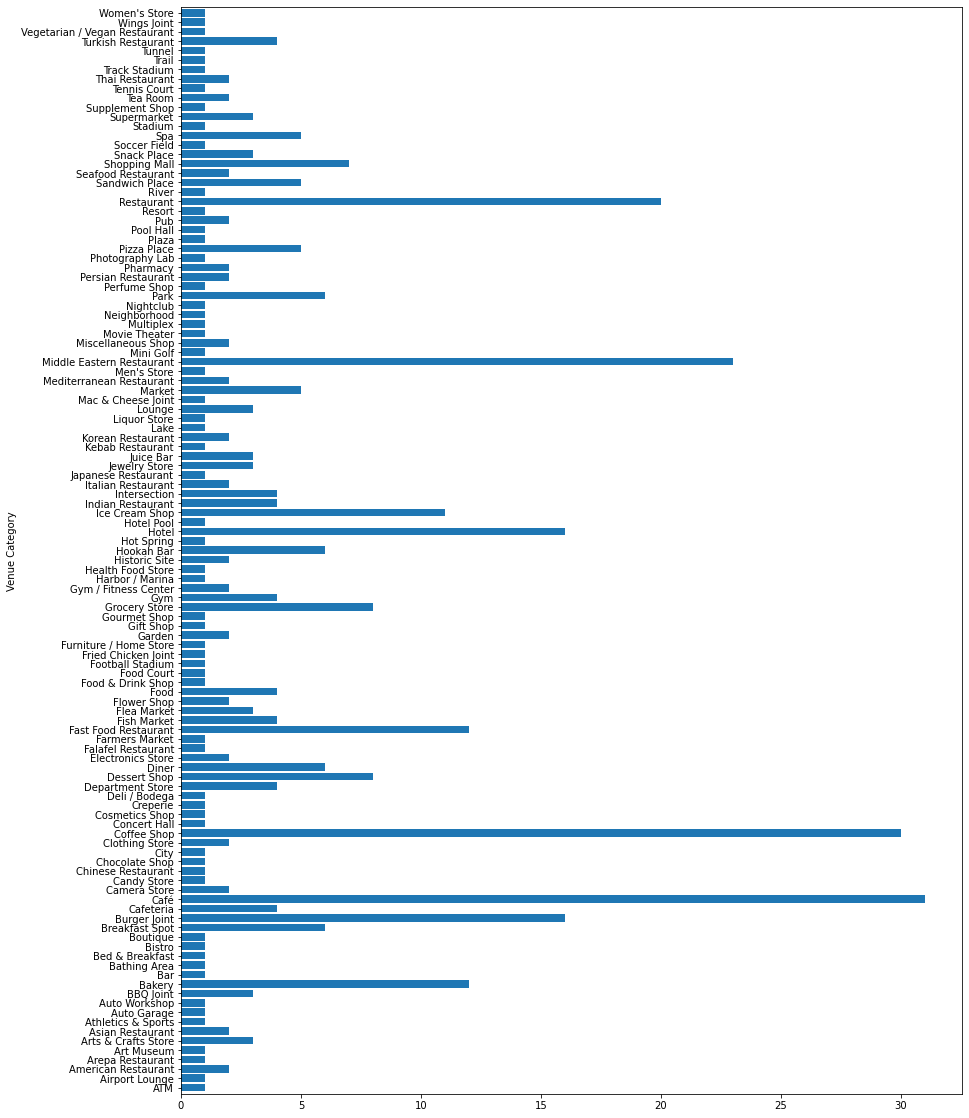

In [11]:
Bh_all_venues_cat.plot(kind='barh',figsize=(14,20),width=0.8,legend=None)
plt.show()

In [12]:
# get unique categories
Bh_all_venues['Venue Category'].unique()

array(['Asian Restaurant', 'Turkish Restaurant',
       'Middle Eastern Restaurant', 'Restaurant', 'BBQ Joint', 'Food',
       'Camera Store', "Men's Store", 'Hookah Bar', 'Spa',
       'Vegetarian / Vegan Restaurant', 'Miscellaneous Shop', 'Hotel',
       'Thai Restaurant', 'Café', 'Coffee Shop', 'Supplement Shop',
       'Burger Joint', 'Indian Restaurant', 'Breakfast Spot',
       'Arepa Restaurant', 'Lounge', 'Diner', 'Jewelry Store',
       'Clothing Store', 'Pub', 'ATM', 'Dessert Shop', 'Market', 'Gym',
       'Park', 'Bakery', 'Fast Food Restaurant', 'Historic Site',
       'Ice Cream Shop', 'Korean Restaurant', 'Pool Hall', 'Boutique',
       'Nightclub', 'Chinese Restaurant', 'Bar', 'Resort',
       'Falafel Restaurant', 'Soccer Field', 'Harbor / Marina',
       'Fish Market', 'Concert Hall', 'Art Museum', 'Deli / Bodega',
       'Chocolate Shop', 'Pizza Place', 'Flea Market',
       'Persian Restaurant', 'Wings Joint', 'Food Court',
       'Kebab Restaurant', 'Department Stor

There are 115 unique catgeories but we will focus on 46 categories that visitor may look for like: hotel ,park , shoping mall , cafe and different cuisines 

In [13]:
desired_list=['Hotel','Spa' ,'Lounge' ,'Resort',"Men's Store",'Boutique','Shopping Mall' ,'Clothing Store',
              'Pharmacy','Historic Site' ,'Art Museum','Movie Theater' , 'Multiplex','Dessert Shop' , 'Café' ,
              'Coffee Shop','Ice Cream Shop','Juice Bar','Cafeteria' , 'Sandwich Place' ,
               'Breakfast Spot','Bakery' , 'Department Store' ,'Grocery Store' ,'Market','Gourmet Shop','Diner',
               'Garden','Park','Gym' ,'Gym / Fitness Center',
              'Thai Restaurant' , 'Asian Restaurant' ,'Chinese Restaurant' , 'Indian Restaurant','Korean Restaurant',
               'Middle Eastern Restaurant' ,'Turkish Restaurant' ,'Restaurant','BBQ Joint',
               'Italian Restaurant','Pizza Place',
                'Fast Food Restaurant' ,'Burger Joint' ,'American Restaurant','Fried Chicken Joint']

In [14]:
# copy original venues dataframe to new 
Bh_venues = Bh_all_venues.copy()

# only desire catgeoy list
Bh_venues = Bh_venues[Bh_venues['Venue Category'].isin(desired_list)].reset_index()
Bh_venues

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
0,0,Manama,26.228,50.586,Bahay Kubo Restaurant,4d07a2f18620224b7e34b940,26.228443,50.582647,Asian Restaurant
1,1,Manama,26.228,50.586,Sameeh pastries,4cb0419acbab236acbc29e73,26.226697,50.588958,Turkish Restaurant
2,2,Manama,26.228,50.586,The Lebanese Restaurant,4d288e6ff7a9224b630ef69f,26.228518,50.583612,Middle Eastern Restaurant
3,3,Manama,26.228,50.586,Al Wasmiya Village Restaurant,4e270708ae609b2f94ecc680,26.229518,50.581646,Restaurant
4,4,Manama,26.228,50.586,Jahan Grills,4dd7f705b0fb8af380937ea3,26.224671,50.587759,BBQ Joint
...,...,...,...,...,...,...,...,...,...
285,385,Al Ḩadd,26.246,50.654,Hidd Co-Operative,4db3c8996e8179a91370f5d4,26.241519,50.656628,Shopping Mall
286,388,Al Ḩadd,26.246,50.654,Jasmis,4f0dd29fe4b040d4823328a8,26.235767,50.649196,Burger Joint
287,389,Al Ḩadd,26.246,50.654,The Dragon,4ece88b9b8f7971d68774ca7,26.235728,50.649080,Hotel
288,390,Al Ḩadd,26.246,50.654,City Center,4fa23f68e4b0736379935d62,26.257322,50.654788,Shopping Mall


lets check size of dataset

In [15]:
print('There are {} venues and {} uniques categories'.format(Bh_venues.shape[0],len(Bh_venues['Venue Category'].unique())))

There are 290 venues and 46 uniques categories


Classify 46 category into 10 main categories

In [16]:
hotel_spa=['Hotel','Spa' ,'Lounge' ,'Resort']
shopping=["Men's Store",'Boutique','Shopping Mall' ,'Clothing Store','Pharmacy']
cinema_museum=['Historic Site' ,'Art Museum','Movie Theater' , 'Multiplex']
cafe_snack=['Dessert Shop' , 'Café','Coffee Shop','Ice Cream Shop','Juice Bar','Cafeteria' , 'Sandwich Place']
breakfast_bakery_diner=['Breakfast Spot','Bakery' , 'Department Store' ,'Grocery Store' ,'Market','Gourmet Shop','Diner']
park_gym=['Garden','Park','Gym' ,'Gym / Fitness Center']
asian_cuisine=['Thai Restaurant' , 'Asian Restaurant' ,'Chinese Restaurant' , 'Indian Restaurant','Korean Restaurant']
mideast_bbq_cuisine=['Middle Eastern Restaurant' ,'Turkish Restaurant' ,'Restaurant','BBQ Joint']
italian_cuisine=['Italian Restaurant','Pizza Place']
fast_food=['Fast Food Restaurant' ,'Burger Joint' ,'American Restaurant','Fried Chicken Joint']

In [17]:
def main_cat(row):
    if row['Venue Category'] in hotel_spa:
        return 'hotel_spa'
    elif row['Venue Category'] in shopping:
        return 'shopping'
    elif row['Venue Category'] in cinema_museum:
        return 'cinema_museum'
    elif row['Venue Category'] in cafe_snack:
        return 'cafe_snack'
    elif row['Venue Category'] in breakfast_bakery_diner:
        return 'breakfast_bakery_diner'
    elif row['Venue Category'] in park_gym:
        return 'park_gym'
    elif row['Venue Category'] in asian_cuisine:
        return 'asian_cuisine'
    elif row['Venue Category'] in mideast_bbq_cuisine:
        return 'mideast_bbq_cuisine'
    elif row['Venue Category'] in italian_cuisine:
        return 'italian_cuisine'
    elif row['Venue Category'] in fast_food:
        return 'fast_food'
    else :
        return 'undefined'

In [18]:
# applu function main_cat and add result ot new column 
Bh_venues['main_category']=Bh_venues.apply(main_cat, axis=1)

In [19]:
Bh_venues.tail(8)

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category
282,380,Al Ḩadd,26.246,50.654,Lulu Hypermarket,4ec7fe1430f8b09c0c9812bb,26.238721,50.651118,Shopping Mall,shopping
283,382,Al Ḩadd,26.246,50.654,Papa John's,4cb6043652edb1f703a86bfe,26.256143,50.648395,Pizza Place,italian_cuisine
284,383,Al Ḩadd,26.246,50.654,Icecream House,5b65c1009e0d54002c49c485,26.250345,50.653430,Ice Cream Shop,cafe_snack
285,385,Al Ḩadd,26.246,50.654,Hidd Co-Operative,4db3c8996e8179a91370f5d4,26.241519,50.656628,Shopping Mall,shopping
286,388,Al Ḩadd,26.246,50.654,Jasmis,4f0dd29fe4b040d4823328a8,26.235767,50.649196,Burger Joint,fast_food
287,389,Al Ḩadd,26.246,50.654,The Dragon,4ece88b9b8f7971d68774ca7,26.235728,50.649080,Hotel,hotel_spa
288,390,Al Ḩadd,26.246,50.654,City Center,4fa23f68e4b0736379935d62,26.257322,50.654788,Shopping Mall,shopping
289,391,Al Ḩadd,26.246,50.654,The Coffee Station,5dd6b57ed892900007d08375,26.256077,50.648135,Coffee Shop,cafe_snack


lets check if main category assigned correctly 

In [20]:
if 'undefined' in Bh_venues['main_category'].values:
    
    print('Ops , undefined is assigned !')
    
else :
     print('No Issue')

No Issue


lets calculate number of venues per main catgory

In [21]:
main_cat=Bh_venues.groupby('main_category').count().iloc[:,-1:]
main_cat

,Venue Category
main_category,
asian_cuisine,11
breakfast_bakery_diner,42
cafe_snack,92
cinema_museum,5
fast_food,31
hotel_spa,25
italian_cuisine,7
mideast_bbq_cuisine,50
park_gym,14


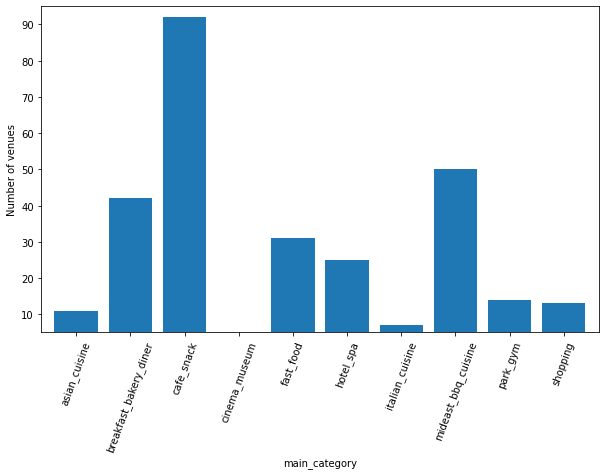

In [22]:
main_cat.plot(kind='bar',figsize=(10,6),width=0.8,legend=None)
plt.ylim(5,95)
plt.ylabel('Number of venues')
plt.xticks(rotation=70)
plt.show()

<h3>Foursquare venue total likes</h3>

In [23]:
def venue_like(venueIDs):
 venue_like_list=[]
 like_list=[]
 for venueid in venueIDs:
   url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venueid, CLIENT_ID, CLIENT_SECRET, VERSION)
   t_likes = requests.get(url).json()['response']['likes']['count']
   like_list.append(t_likes)   
 for k in like_list:
    venue_like_list.append(k)
 return venue_like_list

pass venue id fourquare to get total like

In [24]:
# add result to new column 
Bh_venues['total likes'] = venue_like(Bh_venues['id'])
Bh_venues

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes
0,0,Manama,26.228,50.586,Bahay Kubo Restaurant,4d07a2f18620224b7e34b940,26.228443,50.582647,Asian Restaurant,asian_cuisine,48
1,1,Manama,26.228,50.586,Sameeh pastries,4cb0419acbab236acbc29e73,26.226697,50.588958,Turkish Restaurant,mideast_bbq_cuisine,38
2,2,Manama,26.228,50.586,The Lebanese Restaurant,4d288e6ff7a9224b630ef69f,26.228518,50.583612,Middle Eastern Restaurant,mideast_bbq_cuisine,45
3,3,Manama,26.228,50.586,Al Wasmiya Village Restaurant,4e270708ae609b2f94ecc680,26.229518,50.581646,Restaurant,mideast_bbq_cuisine,11
4,4,Manama,26.228,50.586,Jahan Grills,4dd7f705b0fb8af380937ea3,26.224671,50.587759,BBQ Joint,mideast_bbq_cuisine,55
...,...,...,...,...,...,...,...,...,...,...,...
285,385,Al Ḩadd,26.246,50.654,Hidd Co-Operative,4db3c8996e8179a91370f5d4,26.241519,50.656628,Shopping Mall,shopping,1
286,388,Al Ḩadd,26.246,50.654,Jasmis,4f0dd29fe4b040d4823328a8,26.235767,50.649196,Burger Joint,fast_food,2
287,389,Al Ḩadd,26.246,50.654,The Dragon,4ece88b9b8f7971d68774ca7,26.235728,50.649080,Hotel,hotel_spa,1
288,390,Al Ḩadd,26.246,50.654,City Center,4fa23f68e4b0736379935d62,26.257322,50.654788,Shopping Mall,shopping,3


<h2>Statstics</h2>

In [25]:
Bh_venues[['total likes']].describe()

,total likes
count,290.000000
mean,33.510345
std,75.758048
min,0.000000
25%,6.000000
50%,11.000000
75%,27.000000
max,787.000000


Lets calculate percentile of total likes

In [26]:
print('25th percentile ',np.percentile(Bh_venues['total likes'], 25))
print('50th percentile ',np.percentile(Bh_venues['total likes'], 50))
print('75th percentile ',np.percentile(Bh_venues['total likes'], 75))

25th percentile  6.0
50th percentile  11.0
75th percentile  27.0


<h2>Rating</h2>

Lets define new categorical variable rate venue based on likes

In [27]:
star1=Bh_venues['total likes']<=6
star2=Bh_venues[(Bh_venues['total likes']>6) & (Bh_venues['total likes']<=11)]
star3=Bh_venues[(Bh_venues['total likes']>11) & (Bh_venues['total likes']<=27)]
star4=Bh_venues['total likes']>27

In [28]:
def venue_rate(row):
    if row <=6:
        return 'start1'
    elif row <=11:
        return 'start2'
    elif row <=27:
        return 'star3'
    elif row >27:
        return 'star4'
    else:
        return 'undefined'

In [29]:
#apply function venue_rate and add result to new column
Bh_venues['venue rate']=Bh_venues['total likes'].apply(venue_rate)
Bh_venues

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes,venue rate
0,0,Manama,26.228,50.586,Bahay Kubo Restaurant,4d07a2f18620224b7e34b940,26.228443,50.582647,Asian Restaurant,asian_cuisine,48,star4
1,1,Manama,26.228,50.586,Sameeh pastries,4cb0419acbab236acbc29e73,26.226697,50.588958,Turkish Restaurant,mideast_bbq_cuisine,38,star4
2,2,Manama,26.228,50.586,The Lebanese Restaurant,4d288e6ff7a9224b630ef69f,26.228518,50.583612,Middle Eastern Restaurant,mideast_bbq_cuisine,45,star4
3,3,Manama,26.228,50.586,Al Wasmiya Village Restaurant,4e270708ae609b2f94ecc680,26.229518,50.581646,Restaurant,mideast_bbq_cuisine,11,start2
4,4,Manama,26.228,50.586,Jahan Grills,4dd7f705b0fb8af380937ea3,26.224671,50.587759,BBQ Joint,mideast_bbq_cuisine,55,star4
...,...,...,...,...,...,...,...,...,...,...,...,...
285,385,Al Ḩadd,26.246,50.654,Hidd Co-Operative,4db3c8996e8179a91370f5d4,26.241519,50.656628,Shopping Mall,shopping,1,start1
286,388,Al Ḩadd,26.246,50.654,Jasmis,4f0dd29fe4b040d4823328a8,26.235767,50.649196,Burger Joint,fast_food,2,start1
287,389,Al Ḩadd,26.246,50.654,The Dragon,4ece88b9b8f7971d68774ca7,26.235728,50.649080,Hotel,hotel_spa,1,start1
288,390,Al Ḩadd,26.246,50.654,City Center,4fa23f68e4b0736379935d62,26.257322,50.654788,Shopping Mall,shopping,3,start1


<h2>Clustering</h2>

Lets perform one hot enconding to prepare data for clustering

In [30]:
#pivote based on main category and veneu rate
Bh_onehot = pd.get_dummies(Bh_venues[['main_category','venue rate']], prefix="", prefix_sep="")
Bh_onehot

,asian_cuisine,breakfast_bakery_diner,cafe_snack,cinema_museum,fast_food,hotel_spa,italian_cuisine,mideast_bbq_cuisine,park_gym,shopping,star3,star4,start1,start2
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,0,0,0,0,0,0,0,0,0,1,0,0,1,0
286,0,0,0,0,1,0,0,0,0,0,0,0,1,0
287,0,0,0,0,0,1,0,0,0,0,0,0,1,0
288,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [31]:

#Bh_onehot['City'] = Bh_venues['City'] 
# move neighborhood column to the first column
#fixed_columns = [Bh_onehot.columns[-1]] + list(Bh_onehot.columns[:-1])
#Bh_onehot = Bh_onehot[fixed_columns]

# add City column back to dataframe to first column 
city = Bh_venues['City']
Bh_onehot.insert(0, 'City',city)

Bh_onehot.head(10)

,City,asian_cuisine,breakfast_bakery_diner,cafe_snack,cinema_museum,fast_food,hotel_spa,italian_cuisine,mideast_bbq_cuisine,park_gym,shopping,star3,star4,start1,start2
0,Manama,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Manama,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,Manama,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,Manama,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,Manama,0,0,0,0,0,0,0,1,0,0,0,1,0,0
5,Manama,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6,Manama,0,0,0,0,0,0,0,1,0,0,1,0,0,0
7,Manama,0,0,0,0,0,0,0,1,0,0,0,1,0,0
8,Manama,0,0,0,0,0,0,0,0,0,1,0,0,0,1
9,Manama,0,0,0,0,0,1,0,0,0,0,0,1,0,0


Lets normalize data 

In [32]:
Bh_nrmlz = Bh_onehot.groupby('City').mean().reset_index()
Bh_nrmlz

,City,asian_cuisine,breakfast_bakery_diner,cafe_snack,cinema_museum,fast_food,hotel_spa,italian_cuisine,mideast_bbq_cuisine,park_gym,shopping,star3,star4,start1,start2
0,Al Muharraq,0.021277,0.191489,0.276596,0.021277,0.127660,0.042553,0.021277,0.212766,0.085106,0.000000,0.234043,0.276596,0.191489,0.297872
1,Al Ḩadd,0.000000,0.000000,0.250000,0.000000,0.083333,0.166667,0.083333,0.083333,0.000000,0.333333,0.083333,0.166667,0.500000,0.250000
2,Ar Rifā‘,0.000000,0.144737,0.460526,0.013158,0.144737,0.039474,0.026316,0.105263,0.026316,0.039474,0.368421,0.171053,0.210526,0.250000
3,Dār Kulayb,0.000000,0.200000,0.300000,0.000000,0.000000,0.100000,0.100000,0.100000,0.200000,0.000000,0.100000,0.000000,0.900000,0.000000
4,Jidd Ḩafş,0.041667,0.208333,0.208333,0.041667,0.083333,0.208333,0.000000,0.208333,0.000000,0.000000,0.208333,0.125000,0.500000,0.166667
5,Madīnat Ḩamad,0.000000,0.555556,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.222222,0.000000,0.000000,0.000000,0.888889,0.111111
6,Madīnat ‘Īsá,0.022727,0.113636,0.386364,0.000000,0.159091,0.022727,0.000000,0.181818,0.045455,0.068182,0.250000,0.227273,0.227273,0.295455
7,Manama,0.119403,0.059701,0.238806,0.029851,0.059701,0.164179,0.000000,0.253731,0.029851,0.044776,0.208955,0.462687,0.134328,0.194030
8,Sitrah,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [33]:
Bh_nrmlz_vis=Bh_nrmlz.copy()
Bh_nrmlz_vis.set_index('City',inplace=True)

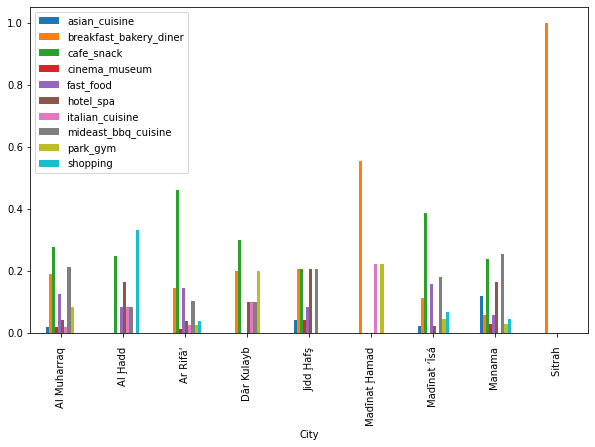

In [34]:
Bh_nrmlz_vis.iloc[:,0:10].plot(kind='bar',figsize=(10,6))
plt.show()

<h2>K-means</h2>

Lets first find optimal value for k

<h4>1- Elbow Method</h4>

In [35]:
# remove city to perform clustring
cluster_df = Bh_onehot.drop('City', axis=1)

In [36]:
SSE = []
K = range(2,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(cluster_df)
    SSE.append(kmeanModel.inertia_)

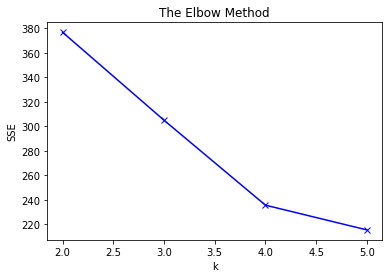

In [37]:
plt.plot(K, SSE,'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method')
plt.show()

Elbow method show optimal value 4 but lets check Silhouette Score method too 

<h4>2- Silhouette Score Method </h4>

In [38]:
scores=[]
for k in range(2,6):
   kmeans_t = KMeans(n_clusters=k, max_iter=1000, random_state=1)
   preds = kmeans_t.fit_predict(cluster_df) 
   centers = kmeans_t.cluster_centers_
   score_t = silhouette_score (cluster_df, preds, metric='euclidean') 
   #print(k,round(score_t,4)) 
   scores.append ({'K':k,
                  'Score':round(score_t,4)
   })
scores_df=pd.DataFrame(scores) 
scores_df

,K,Score
0,2,0.2015
1,3,0.2882
2,4,0.3807
3,5,0.3485


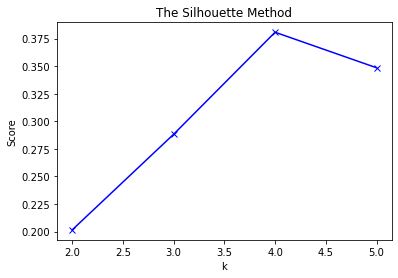

In [39]:
plt.plot(scores_df['K'],scores_df['Score'],'bx-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('The Silhouette Method')
plt.show()

Lets run K-Means clustering with 4 clusters

In [40]:
# set number of clusters
kclusters =4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans_labels=kmeans.labels_
kmeans_labels

array([3, 3, 3, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1,
       3, 3, 1, 1, 2, 1, 0, 3, 1, 2, 3, 1, 2, 1, 3, 1, 2, 3, 3, 3, 2, 3,
       2, 2, 0, 2, 3, 2, 1, 1, 1, 2, 3, 2, 3, 3, 3, 1, 0, 3, 0, 0, 0, 0,
       0, 2, 1, 3, 3, 1, 3, 2, 3, 1, 2, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 2,
       3, 3, 2, 2, 1, 0, 3, 2, 1, 3, 2, 2, 2, 2, 2, 0, 2, 3, 0, 2, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 3, 2, 1, 2, 3,
       3, 3, 1, 2, 2, 3, 1, 2, 2, 2, 1, 3, 1, 1, 3, 1, 2, 2, 1, 0, 2, 1,
       2, 2, 3, 1, 0, 3, 1, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 3,
       0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 3, 3, 3, 3, 2, 1, 3,
       2, 3, 3, 2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 0, 3, 2, 2, 1, 0, 1, 1, 2,
       1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 3, 3, 3, 2,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 2, 3, 2, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [41]:
# add cluster label to main data frame 
Bh_venues['Cluster label'] = kmeans_labels
Bh_venues.head()

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes,venue rate,Cluster label
0,0,Manama,26.228,50.586,Bahay Kubo Restaurant,4d07a2f18620224b7e34b940,26.228443,50.582647,Asian Restaurant,asian_cuisine,48,star4,3
1,1,Manama,26.228,50.586,Sameeh pastries,4cb0419acbab236acbc29e73,26.226697,50.588958,Turkish Restaurant,mideast_bbq_cuisine,38,star4,3
2,2,Manama,26.228,50.586,The Lebanese Restaurant,4d288e6ff7a9224b630ef69f,26.228518,50.583612,Middle Eastern Restaurant,mideast_bbq_cuisine,45,star4,3
3,3,Manama,26.228,50.586,Al Wasmiya Village Restaurant,4e270708ae609b2f94ecc680,26.229518,50.581646,Restaurant,mideast_bbq_cuisine,11,start2,2
4,4,Manama,26.228,50.586,Jahan Grills,4dd7f705b0fb8af380937ea3,26.224671,50.587759,BBQ Joint,mideast_bbq_cuisine,55,star4,3


In [42]:
address = 'Bahrain'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_bh = location.latitude
longitude_bh = location.longitude
print('The geograpical coordinate of Bahrin Island are {}, {}.'.format(latitude_bh, longitude_bh))

The geograpical coordinate of Bahrin Island are 26.1551249, 50.5344606.


In [47]:
# create map
map_clusters = folium.Map(location=[latitude_bh, longitude_bh], zoom_start=11)

# set the color scheme for the clusters and add markers to the map
colors = ['yellow','blue','green','red']
fillers = ['yellow','blue','green','red']

# add markers to the map
markers_colors = []
for lat, lon, vn, vn_cat ,cluster in zip(Bh_venues['Venue Latitude'], Bh_venues['Venue Longitude'], Bh_venues['Venue'],Bh_venues['main_category']
                                         ,Bh_venues['Cluster label']):
    label = folium.Popup(str(vn) + ' ,'+ str(vn_cat)+',  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=fillers[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a href='https://github.com/mrym92/Coursera_Capstone/blob/master/map.PNG'>Click to view map</a>

<a href='https://github.com/mrym92/Coursera_Capstone/blob/master/map_zoom.PNG'>Click to view detailed map</a>

<h2>Results and Discussion</h2>

lets first examin number of venues per cluster and rate

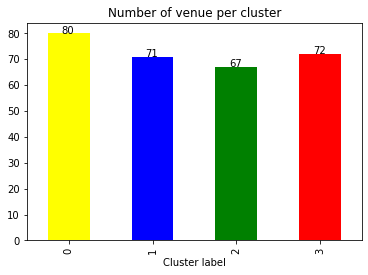

In [75]:
colors = ['yellow','blue','green','red']
ax=Bh_venues.groupby('Cluster label')['Venue'].count().plot(kind='bar',color=colors)
for a in ax.patches:
    width,height= a.get_width(),a.get_height()
    x,y=a.get_xy()
    ax.annotate('{:}'.format(height),(x+width/3,y+height+0.02))
ax.set_title('Number of venue per cluster')    
plt.show()

The hightest number of venues in cluster 0 then cluster 3,1 with 72,71 venues respectively and cluster 2 with least of 67 venues

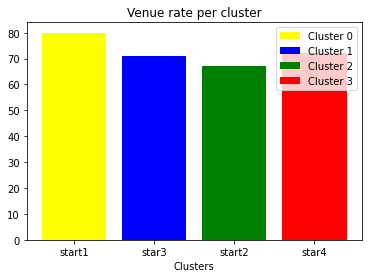

In [77]:
plt1=Bh_venues.loc[Bh_venues['Cluster label']==0].groupby('venue rate')['Venue'].count().reset_index()
plt2=Bh_venues.loc[Bh_venues['Cluster label']==1].groupby('venue rate')['Venue'].count().reset_index()
plt3=Bh_venues.loc[Bh_venues['Cluster label']==2].groupby('venue rate')['Venue'].count().reset_index()
plt4=Bh_venues.loc[Bh_venues['Cluster label']==3].groupby('venue rate')['Venue'].count().reset_index()

plt.bar(plt1['venue rate'],plt1['Venue'],label='Cluster 0',color='yellow')
plt.bar(plt2['venue rate'],plt2['Venue'],label='Cluster 1',color='blue')
plt.bar(plt3['venue rate'],plt3['Venue'],label='Cluster 2',color='green')
plt.bar(plt4['venue rate'],plt4['Venue'],label='Cluster 3',color='red')

# call with no parameters
plt.legend()
plt.xlabel("Clusters")
plt.title('Venue rate per cluster')
plt.show()

cluster 3 has best rating of 4 stars while cluster 0 least rating of one star

  <h3>Cluster 1</h3>

In [58]:
Bh_venues.loc[Bh_venues['Cluster label']==0]

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes,venue rate,Cluster label
15,22,Manama,26.228,50.586,Burger Town,4c0ff7b2ce57c9288b1e81d2,26.219904,50.588621,Burger Joint,fast_food,6,start1,0
28,39,Manama,26.228,50.586,Starbucks,4c18c8bfd4d9c9289bdeef29,26.220146,50.588724,Coffee Shop,cafe_snack,3,start1,0
46,59,Manama,26.228,50.586,مشويات جهان,4ea47ec72c5b5cb4f4dd50de,26.232488,50.597938,Restaurant,mideast_bbq_cuisine,6,start1,0
60,77,Manama,26.228,50.586,Kudu,505f2ecce4b0f0e1a26ff4a0,26.225711,50.596506,Fast Food Restaurant,fast_food,6,start1,0
62,79,Manama,26.228,50.586,M Beauty Lounge,5246df09498e710a0505e2be,26.225509,50.596481,Spa,hotel_spa,2,start1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,385,Al Ḩadd,26.246,50.654,Hidd Co-Operative,4db3c8996e8179a91370f5d4,26.241519,50.656628,Shopping Mall,shopping,1,start1,0
286,388,Al Ḩadd,26.246,50.654,Jasmis,4f0dd29fe4b040d4823328a8,26.235767,50.649196,Burger Joint,fast_food,2,start1,0
287,389,Al Ḩadd,26.246,50.654,The Dragon,4ece88b9b8f7971d68774ca7,26.235728,50.649080,Hotel,hotel_spa,1,start1,0
288,390,Al Ḩadd,26.246,50.654,City Center,4fa23f68e4b0736379935d62,26.257322,50.654788,Shopping Mall,shopping,3,start1,0


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


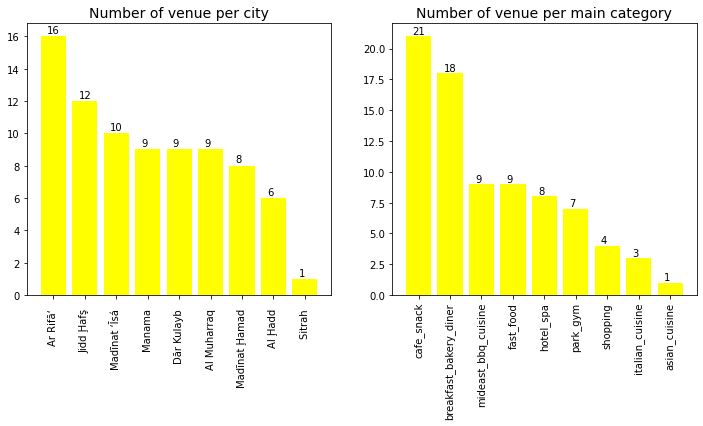

In [78]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
plt1=Bh_venues.loc[Bh_venues['Cluster label']==0].groupby('City')['Venue'].count().sort_values(ascending=False).reset_index()
plt2=Bh_venues.loc[Bh_venues['Cluster label']==0].groupby('main_category')['Venue'].count().sort_values(ascending=False).reset_index()

ax1.bar(plt1['City'],plt1['Venue'],color='yellow')
ax1.set_xticklabels(plt1['City'], rotation=90)
ax1.set_title("Number of venue per city",fontsize=14)
for a in ax1.patches:
    width,height= a.get_width(),a.get_height()
    x,y=a.get_xy()
    ax1.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

ax2.bar(plt2['main_category'],plt2['Venue'],color='yellow')
ax2.set_xticklabels(plt2['main_category'], rotation=90)
ax2.set_title("Number of venue per main category",fontsize=14)
for b in ax2.patches:
    width,height= b.get_width(),b.get_height()
    x,y=b.get_xy()
    ax2.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

plt.show()

Cluster 0, has 80 venues with lowest rating (1 star) where mainly located at Ar Rifa city. The most common categories are food, hotels, park and shopping. There are many coffee shops, breakfast and different cuisines like Middle East, Italian and Asian

<h3>Cluster 1</h3>

In [65]:
Bh_venues.loc[Bh_venues['Cluster label']==1]

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes,venue rate,Cluster label
6,6,Manama,26.228,50.586,تكة أمين,51d09d47498e2a039a702d75,26.228616,50.585451,BBQ Joint,mideast_bbq_cuisine,12,star3,1
17,24,Manama,26.228,50.586,Aalo Basheer (آلو بشير),4e0c964314954f127e67d179,26.231231,50.576993,Indian Restaurant,asian_cuisine,24,star3,1
21,29,Manama,26.228,50.586,Badawi Lebanese restaurant,50c24068e4b09f38abc0d717,26.234796,50.592531,Diner,breakfast_bakery_diner,22,star3,1
24,33,Manama,26.228,50.586,Cafeier Cafe,5c0d6262e55d8b002c410a4a,26.217356,50.589505,Café,cafe_snack,23,star3,1
25,34,Manama,26.228,50.586,Van cleef & Arpels,4eba82db6c259b4ac4063980,26.239032,50.582194,Clothing Store,shopping,20,star3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,341,Jidd Ḩafş,26.219,50.548,Adam Oven & Broasted,4e6f175cb0fbacf2ad9a63e5,26.220709,50.535891,Middle Eastern Restaurant,mideast_bbq_cuisine,15,star3,1
257,344,Jidd Ḩafş,26.219,50.548,Tulip inn suites and residences,51ceabe6498e00f50075dd90,26.229867,50.550974,Hotel,hotel_spa,25,star3,1
265,356,Jidd Ḩafş,26.219,50.548,Al Hantour Restaurant,4e41991f183853a18e457f82,26.209140,50.549314,Turkish Restaurant,mideast_bbq_cuisine,13,star3,1
267,358,Jidd Ḩafş,26.219,50.548,Hotel Ibis Restaurant,557cff38498e12f141abf5d5,26.229807,50.551369,Restaurant,mideast_bbq_cuisine,15,star3,1


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


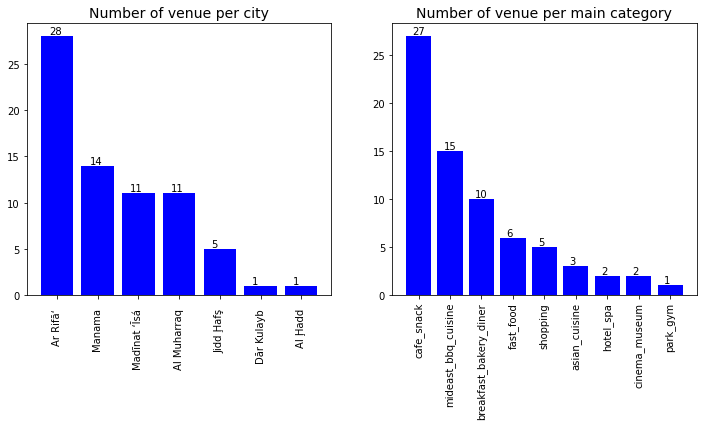

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
plt1=Bh_venues.loc[Bh_venues['Cluster label']==1].groupby('City')['Venue'].count().sort_values(ascending=False).reset_index()
plt2=Bh_venues.loc[Bh_venues['Cluster label']==1].groupby('main_category')['Venue'].count().sort_values(ascending=False).reset_index()

ax1.bar(plt1['City'],plt1['Venue'],color='blue')
ax1.set_xticklabels(plt1['City'], rotation=90)
ax1.set_title("Number of venue per city",fontsize=14)
for a in ax1.patches:
    width,height= a.get_width(),a.get_height()
    x,y=a.get_xy()
    ax1.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

ax2.bar(plt2['main_category'],plt2['Venue'],color='blue')
ax2.set_xticklabels(plt2['main_category'], rotation=90)
ax2.set_title("Number of venue per main category",fontsize=14)
for b in ax2.patches:
    width,height= b.get_width(),b.get_height()
    x,y=b.get_xy()
    ax2.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

plt.show()

Cluster 1, has 71 venues of 3 star rating where mainly located at Ar Rifa city. The most common categories are food, shopping, hotel, cinema, museum and park. There are many coffee shops, breakfast and different cuisines like Middle East, fast food and Asian

<h3>Cluster 2</h3>

In [67]:
Bh_venues.loc[Bh_venues['Cluster label']==2]

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes,venue rate,Cluster label
3,3,Manama,26.228,50.586,Al Wasmiya Village Restaurant,4e270708ae609b2f94ecc680,26.229518,50.581646,Restaurant,mideast_bbq_cuisine,11,start2,2
8,10,Manama,26.228,50.586,Dolce & Gabbana,52d82e6511d251866f31f63a,26.231304,50.582644,Men's Store,shopping,7,start2,2
26,37,Manama,26.228,50.586,Showaiter Sweets (حلويات شويطر),50129c80e4b0c3d590e5ad5d,26.232316,50.594947,Dessert Shop,cafe_snack,8,start2,2
31,42,Manama,26.228,50.586,Al Gosaybi Gym,4e81eca40aaf4e1e90c3e472,26.227613,50.596172,Gym,park_gym,10,start2,2
34,46,Manama,26.228,50.586,Burger King,4d00bbb40457b1f7e0bf3278,26.233444,50.594620,Fast Food Restaurant,fast_food,9,start2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,354,Jidd Ḩafş,26.219,50.548,مطعم شمس العراق,4f653c7ae4b0bca4630a075f,26.216219,50.539285,American Restaurant,fast_food,8,start2,2
277,374,Jidd Ḩafş,26.219,50.548,Al Raya Suites,4cc8352bf2d43704bc70cd6c,26.227990,50.540846,Hotel,hotel_spa,7,start2,2
278,376,Al Ḩadd,26.246,50.654,Alta Cafe,5c23be204ac28a002c526160,26.239502,50.651604,Coffee Shop,cafe_snack,8,start2,2
281,379,Al Ḩadd,26.246,50.654,Salemak Bacha پاچه ساليمك,5995f75862420b7f4b6a94c8,26.245110,50.654366,Middle Eastern Restaurant,mideast_bbq_cuisine,8,start2,2


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


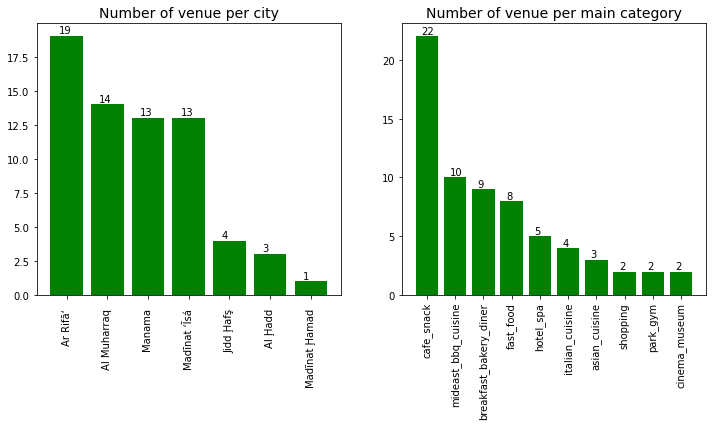

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
plt1=Bh_venues.loc[Bh_venues['Cluster label']==2].groupby('City')['Venue'].count().sort_values(ascending=False).reset_index()
plt2=Bh_venues.loc[Bh_venues['Cluster label']==2].groupby('main_category')['Venue'].count().sort_values(ascending=False).reset_index()

ax1.bar(plt1['City'],plt1['Venue'],color='green')
ax1.set_xticklabels(plt1['City'], rotation=90)
ax1.set_title("Number of venue per city",fontsize=14)
for a in ax1.patches:
    width,height= a.get_width(),a.get_height()
    x,y=a.get_xy()
    ax1.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

ax2.bar(plt2['main_category'],plt2['Venue'],color='green')
ax2.set_xticklabels(plt2['main_category'], rotation=90)
ax2.set_title("Number of venue per main category",fontsize=14)
for b in ax2.patches:
    width,height= b.get_width(),b.get_height()
    x,y=b.get_xy()
    ax2.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

plt.show()

Cluster 2 has 67 venues of  2 star rating where mainly located at Riffa , Muharraq , Manama and Madinat Isa. The most common categories are food, ,hotel, shopping ,park and cinema. There are many coffee shops , breakfast and different cuisines like middle east ,fast food , Italian and Asian

<h3>Cluster 3</h3>

In [69]:
Bh_venues.loc[Bh_venues['Cluster label']==3]

,index,City,Latitude,Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,main_category,total likes,venue rate,Cluster label
0,0,Manama,26.228,50.586,Bahay Kubo Restaurant,4d07a2f18620224b7e34b940,26.228443,50.582647,Asian Restaurant,asian_cuisine,48,star4,3
1,1,Manama,26.228,50.586,Sameeh pastries,4cb0419acbab236acbc29e73,26.226697,50.588958,Turkish Restaurant,mideast_bbq_cuisine,38,star4,3
2,2,Manama,26.228,50.586,The Lebanese Restaurant,4d288e6ff7a9224b630ef69f,26.228518,50.583612,Middle Eastern Restaurant,mideast_bbq_cuisine,45,star4,3
4,4,Manama,26.228,50.586,Jahan Grills,4dd7f705b0fb8af380937ea3,26.224671,50.587759,BBQ Joint,mideast_bbq_cuisine,55,star4,3
5,5,Manama,26.228,50.586,تكة ابل,4f26d629e4b02a9500c19159,26.229502,50.591782,Restaurant,mideast_bbq_cuisine,84,star4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,349,Jidd Ḩafş,26.219,50.548,Hotel Ibis Seef Manama,54881759498e68db46d6e780,26.229667,50.551292,Hotel,hotel_spa,245,star4,3
261,351,Jidd Ḩafş,26.219,50.548,Chai Cafe,4f70bca9e4b031ed86c334c5,26.227309,50.538863,Café,cafe_snack,105,star4,3
262,352,Jidd Ḩafş,26.219,50.548,Al Raya Suites Manama,4bdedf72fe0e62b5fd030606,26.227768,50.541043,Hotel,hotel_spa,37,star4,3
279,377,Al Ḩadd,26.246,50.654,جزر امواج,53dae59b498e1b6df9e9b31e,26.254923,50.659564,Lounge,hotel_spa,53,star4,3


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


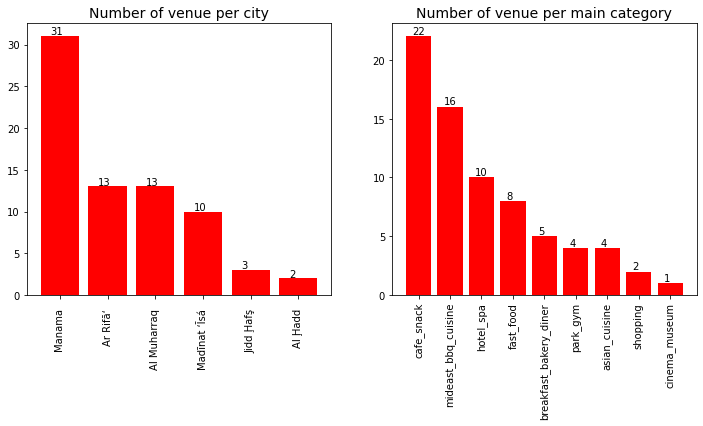

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
plt1=Bh_venues.loc[Bh_venues['Cluster label']==3].groupby('City')['Venue'].count().sort_values(ascending=False).reset_index()
plt2=Bh_venues.loc[Bh_venues['Cluster label']==3].groupby('main_category')['Venue'].count().sort_values(ascending=False).reset_index()

ax1.bar(plt1['City'],plt1['Venue'],color='red')
ax1.set_xticklabels(plt1['City'], rotation=90)
ax1.set_title("Number of venue per city",fontsize=14)
for a in ax1.patches:
    width,height= a.get_width(),a.get_height()
    x,y=a.get_xy()
    ax1.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

ax2.bar(plt2['main_category'],plt2['Venue'],color='red')
ax2.set_xticklabels(plt2['main_category'], rotation=90)
ax2.set_title("Number of venue per main category",fontsize=14)
for b in ax2.patches:
    width,height= b.get_width(),b.get_height()
    x,y=b.get_xy()
    ax2.annotate('{:}'.format(height),(x+width/4,y+height+0.2))

plt.show()

Cluster 3, has 72 venues and best rating among other clusters and mainly located in Manama city. The most common categories are food, hotel, park, shopping, cinema and museum. There are many coffee shops, breakfast and different cuisines like Middle East, fast food and Asian.   

<h5>Thank you for your time and interest </h5>